## Nested Dissection Algorithm

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random


np.random.seed(2023)

def matrix2graph(matrix:np.array, visualize=False):
    """
    convert matrix into graph
    :param matrix: positive definite (PD) matrix 
    :return: an undirected graph
    """
    G = nx.Graph()
    # add nodes
    n = matrix.shape[0]
    nodes = range(n)
    G.add_nodes_from(nodes)
    # add edge
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i,j] != 0:
                G.add_edge(i, j)
    # visualize
    if visualize:
        nx.draw(G, with_labels=True)
    return G

def mesh_matrix(g_size:int) -> np.array:
    """
    create mesh-like (planar) PD matrix, 
    :param g_size: size of the related graph
    :return: positive definite matrix
    """
    # matrix width
    m_size = g_size**2 
    mx = np.identity(m_size)*10
    for i in range(m_size):
        if (i+1) % g_size == 1:
            mx[i][i+1] = 1
        elif (i+1) % g_size == 0:
            mx[i][i-1] = 1
        else:
            mx[i][i-1] = 1
            mx[i][i+1] = 1
    j = 0
    for i in range(g_size, m_size):
        mx[i][j] = 1
        mx[j][i] = 1
        j += 1
    return mx


def random_m(size, density=0.02, visualize=False):
    """
    generate a sparse random matrix
    """
    # generate a random sparse matrix
    S = random(size, size, density=density, format='csr') 
    S = np.dot(S.T,S)
    S = S + 0.1*np.identity(size) 
    if visualize:
        plt.figure()
        plt.spy(S.A)
    return S


def subGraphs(G) -> list:
    """
    find all connected components of the graph
    :param G: Networkx undirected graph
    :return: a list of connected graphes
    """
    comps = nx.connected_components(G)
    # the last subgraph is the biggest one
    comps = sorted(list(comps), key = len)
    sub_graphs = [G.subgraph(nodes).copy() for nodes in comps]
    return sub_graphs


def level_set_algo(G, root) -> list:
    """
    find the level set with respect to a root vertex
    :param G: Networkx undirected graph
    :param root: root vertex, the starting point
    :return: level set, ordered by distance
    """

    pathes = nx.single_source_shortest_path(G,root)
    pathes_length = [len(route) - 1 for route in pathes.values()]
    pathes_nodes = list(pathes.keys())
    level_set = []
    for i, vertex in enumerate(pathes_nodes):
        if pathes_length[i] == pathes_length[i-1]:
            level_set[-1].append(vertex)
        else:
            level_set.append([vertex])
    
    return level_set


def diameter_pair_algo(G) -> set:
    """
    find one pseudo-diameter pair
    :param G: Networkx undirected graph
    :return: a pair of mutual-extremal vertexes (s,t)
    """
    s = np.random.choice(G.nodes)
    while True:
        level_set = level_set_algo(G,s)
        # find th extremal w.r.t root
        t = np.random.choice(level_set[-1])
        level_set_n = level_set_algo(G,t)
        if len(level_set) == len(level_set_n):
            return (s,t)
        s = t

def cost_1(B,W,S, ALPHA=4.0) -> np.float32:
    """
    To evaluate the partition balance
    Ashcraft C, Duff I, Hogg J, et al. Nested dissection revisited[R]. 2016.

    :param S: the set of the seperating vertex
    :param B: the left set of vertex partitioned by seperator (Black)
    :param W: the right set of vertex partitioned by seperator (White)
    :return: a pair of mutual-extremal vertexes (s,t)
    """
    B_len = sum([len(sub_list) for sub_list in B])
    W_len = sum([len(sub_list) for sub_list in W])
    S_len = len(S)
    # imbalance index:
    imb = max(B_len, W_len) / min(B_len, W_len)
    if imb < ALPHA:
        cost = S_len/(B_len+W_len)
    else:
        cost = (B_len + W_len + S_len) - 2 + S_len/(B_len+W_len)
    return cost


def single_partition(G, ALPHA=4.0):
    """
    single layer level set based partition algorithm.
    The function also filter the multiple connected graphes during partition.
    This is  emhanced method of GeorgeLiu Algo with cost function (Ashcraft, 2016)

    :param G: Networkx undirected graph
    :param ALPHA: hyper-parameter to control the partition balance
    :return: 1. A list containing the seperator vertices
             2. A list containing the partitioned graphes
    """

    if not nx.is_connected(G):
        sub_graphs = subGraphs(G)
        main_G = sub_graphs[0]
        subs = sub_graphs[1:]
    else:
        main_G = G
        subs = []

    s,_ = diameter_pair_algo(main_G)
    level_set = level_set_algo(main_G,s)

    cost = np.Inf
    partition = {}
    for i in range(1,len(level_set)-1):
        # construct partition set
        B = level_set[:i]
        W = level_set[i+1:]
        S = level_set[i]
        
        cur_cost = cost_1(B,W,S, ALPHA)
        if cur_cost < cost:
            partition["B"] = B
            partition["W"] = W
            partition["S"] = S
            cost = cur_cost

    # remove the redundant vertex in seperator
    # move the redundant vertex to B
    B = partition["B"]
    W = partition["W"]
    S = partition["S"]
    adj_nodes = []
    for node in W[0]:
        adj_nodes += list(G.adj[node])
    redundant_nodes = [node for node in S if node not in adj_nodes]
    if redundant_nodes:
        S = [node for node in S if node not in redundant_nodes]
        B.append(redundant_nodes)
        partition["B"] = B
        partition["S"] = S


    # generate partitioned graphs from node list
    # detect the sub-graphs
    graphs = []

    B = [item for sublist in partition["B"] for item in sublist]
    W = [item for sublist in partition["W"] for item in sublist]
    S = partition["S"]
    partitioned_graphs = [G.subgraph(c).copy() for c in [W,B]]
    for partitioned_graph in partitioned_graphs:
        if nx.is_connected(partitioned_graph):
            graphs.append(partitioned_graph)
        else:
            graphs += subGraphs(partitioned_graph)

    graphs += subs
   
    return S, graphs



def permute(mtrx, p):
    """
    permute the matrix
    """
    I = np.identity(mtrx.shape[0])
    I = I[p]
    return I@mtrx@I.T


def singleton(G):
    """
    filtering out the isolated vertices
    """
    if len(list(G.nodes)) > 1:
        iso_nodes = [i[0] for i in list(G.degree)if i[1] == 0]
    else:
        iso_nodes = []
    return iso_nodes

def ND_solve(G,p) -> list:
    """
    main function to excecute the partition recursively
    :param p: the list of reordered vertex index
    :return: the reordered index of vertexes
    """

    # filtering the isolated vertex
    iso_nodes = singleton(G)
    p += iso_nodes
    for node in iso_nodes:
        G.remove_node(node)

    if len(list(G.nodes)) <= 2:
        p += list(G.nodes)
        return 
    
    seperator, sub_graphs = single_partition(G)

    for sub_graph in sub_graphs:
        ND_solve(sub_graph,p)
   
    p += seperator
    return p





## Test case 1
Toy

[6, 0, 1, 12, 7, 3, 4, 2, 8, 10, 20, 16, 15, 5, 11, 14, 22, 24, 18, 19, 23, 9, 13, 17, 21]


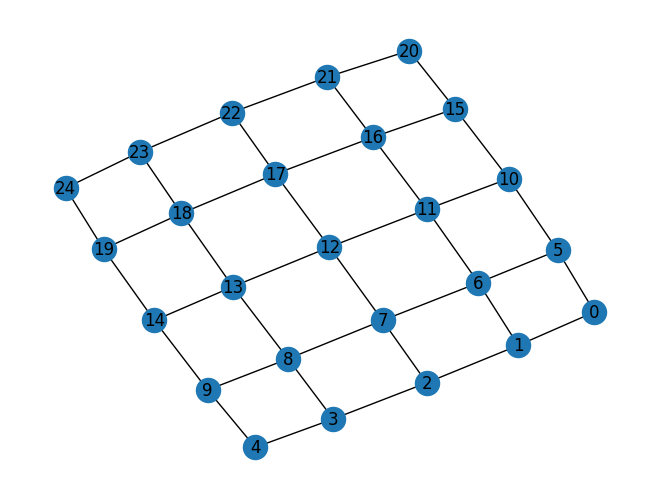

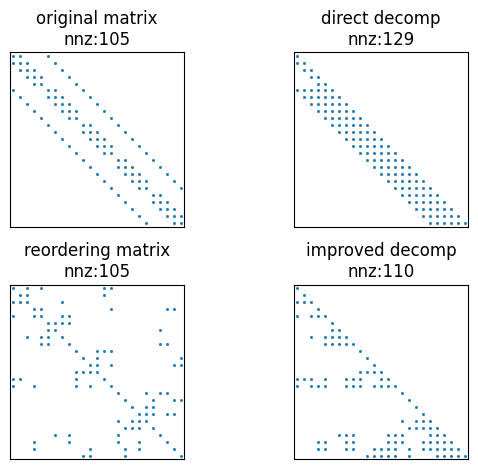

In [4]:
np.random.seed(10)
# test case 1
mtrix = mesh_matrix(5)
G = matrix2graph(mtrix,True)
p = ND_solve(G,[])
new_mtrix = permute(mtrix,p)
print(p)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.spy(mtrix, markersize=1)
ax1.set_title("original matrix\nnnz:{}".format(np.count_nonzero(mtrix)))

L = np.linalg.cholesky(mtrix)
ax2.spy(L, markersize=1)
ax2.set_title("direct decomp\nnnz:{}".format(np.count_nonzero(L)))
ax3.spy(new_mtrix, markersize=1)
ax3.set_title("reordering matrix\nnnz:{}".format(np.count_nonzero(new_mtrix)))

L_ = np.linalg.cholesky(new_mtrix)
ax4.spy(L_, markersize=1)
ax4.set_title("improved decomp\nnnz:{}".format(np.count_nonzero(L_)))
# fig.autofmt_xdate()
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
plt.tight_layout()


## Test case 2
200x200 random


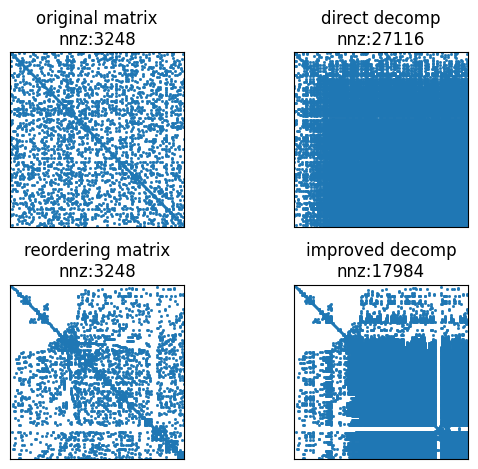

In [82]:
np.random.seed(2023)

mtrix = random_m(200)
G = matrix2graph(mtrix)
p = ND_solve(G,[])

# permutation
I = np.identity(mtrix.shape[0])
I = I[p]
new_mtrix = I@mtrix@I.T



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.spy(mtrix, markersize=1)
ax1.set_title("original matrix\nnnz:{}".format(np.count_nonzero(mtrix)))

L = np.linalg.cholesky(mtrix)
L = L+L.T
ax2.spy(L, markersize=1)
ax2.set_title("direct decomp\nnnz:{}".format(np.count_nonzero(L)))

ax3.spy(new_mtrix, markersize=1)
ax3.set_title("reordering matrix\nnnz:{}".format(np.count_nonzero(new_mtrix)))

L_ = np.linalg.cholesky(new_mtrix)
L_ += L_.T
ax4.spy(L_, markersize=1)
ax4.set_title("improved decomp\nnnz:{}".format(np.count_nonzero(L_)))
# fig.autofmt_xdate()
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
plt.tight_layout()

## Test case 3:
west0739 benchmark

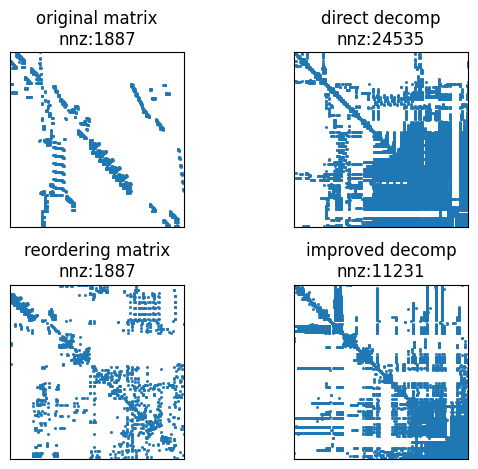

In [81]:
import scipy.io
import numpy as np
from scipy.linalg import lu

mtrix = scipy.io.loadmat('./TestData/matrix.mat')['west0479'].toarray()

G = matrix2graph(mtrix,False)
p = ND_solve(G,[])
new_mtrix = permute(mtrix,p)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.spy(mtrix, markersize=1)
ax1.set_title("original matrix\nnnz:{}".format(np.count_nonzero(mtrix)))

# L = np.linalg.cholesky(mtrix)
_, L, _ = lu(mtrix)
L += L.T
ax2.spy(L, markersize=1)
ax2.set_title("direct decomp\nnnz:{}".format(np.count_nonzero(L)))
ax3.spy(new_mtrix, markersize=1)
ax3.set_title("reordering matrix\nnnz:{}".format(np.count_nonzero(new_mtrix)))

# L_ = np.linalg.cholesky(new_mtrix)
_, L_, _ = lu(new_mtrix)
L_ += L_.T
ax4.spy(L_, markersize=1)
ax4.set_title("improved decomp\nnnz:{}".format(np.count_nonzero(L_)))
# fig.autofmt_xdate()
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
plt.tight_layout()

## Existing Issue:
1. How to find a good seperator?

    
2. ~~How to deal with the multuple seperating tree ?~~ 

    Current solution:
    
    Detect multiple connected components during partition / expand the binary tree